In [1]:
import os
import scanpy
import anndata
import scanpy as sc
import pandas as pd
import numpy as np
import scipy
from scipy import stats
import re
import sklearn
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
from collections import Counter
import random
import seaborn
import sys
import shutil
import scvelo as scv
import bbknn
import tqdm
#Load my pipeline functions
import importlib
import importlib.util
spec = importlib.util.spec_from_file_location("ScanpyUtilsMT", os.path.expanduser("../../utils/ScanpyUtilsMT.py"))
sc_utils = importlib.util.module_from_spec(spec)
spec.loader.exec_module(sc_utils)
sc.settings.figdir='/wynton/group/ye/mtschmitz/figures/mouseTesting/'
scv.settings.figdir='/wynton/group/ye/mtschmitz/figures/mouseTesting/'
sc.settings.file_format_figs='pdf'
sc.settings.autosave=False
sc.settings.autoshow=True

In [2]:
adata=sc.read('/wynton/group/ye/mtschmitz/macaquedevbrain/CAT202002_h5ad/KDCbVelocityMouseWbAdultCortexProcessed.h5ad')

In [3]:
adata=adata[~adata.obs.leiden.isin(['32','11','43','45','48','44','50','37']),:]

In [4]:
adata=adata[:,adata.var['highly_variable']]

In [5]:
adata.obs.drop('percent_mito',axis=1,inplace=True)
adata.obs.drop('percent_ribo',axis=1,inplace=True)
adata.obs.drop('latent_RT_efficiency',axis=1,inplace=True)
adata.obs.drop('latent_cell_probability',axis=1,inplace=True)

In [6]:
adata.var=adata.var.loc[:,adata.var.columns.str.contains('id-|feature_type|name-')]

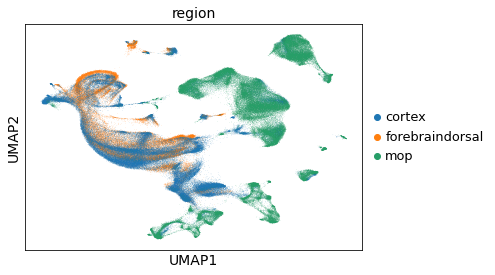

In [5]:
%matplotlib inline
sc.pl.umap(adata,color='region')

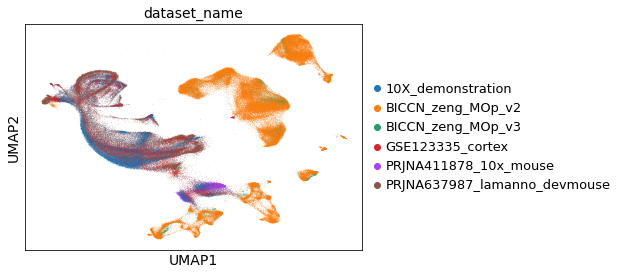

In [8]:
sc.pl.umap(adata,color='dataset_name')

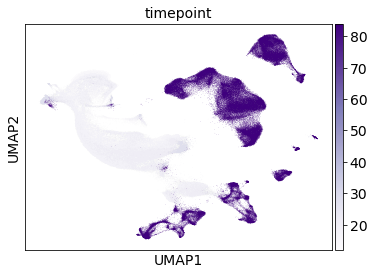

In [9]:
sc.pl.umap(adata,color='timepoint')

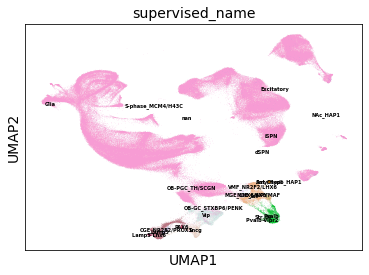

In [10]:
sc.pl.umap(adata,color='supervised_name',legend_loc='on data',legend_fontsize=5)

... storing 'dev_excit' as categorical


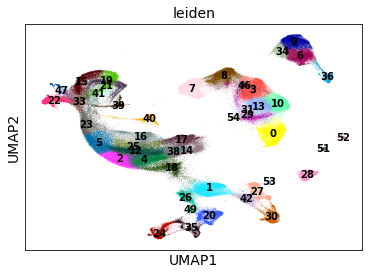

In [12]:
sc.pl.umap(adata,color='leiden',legend_loc='on data')

In [13]:
adata.obs['Adult']=adata.obs['timepoint']>31

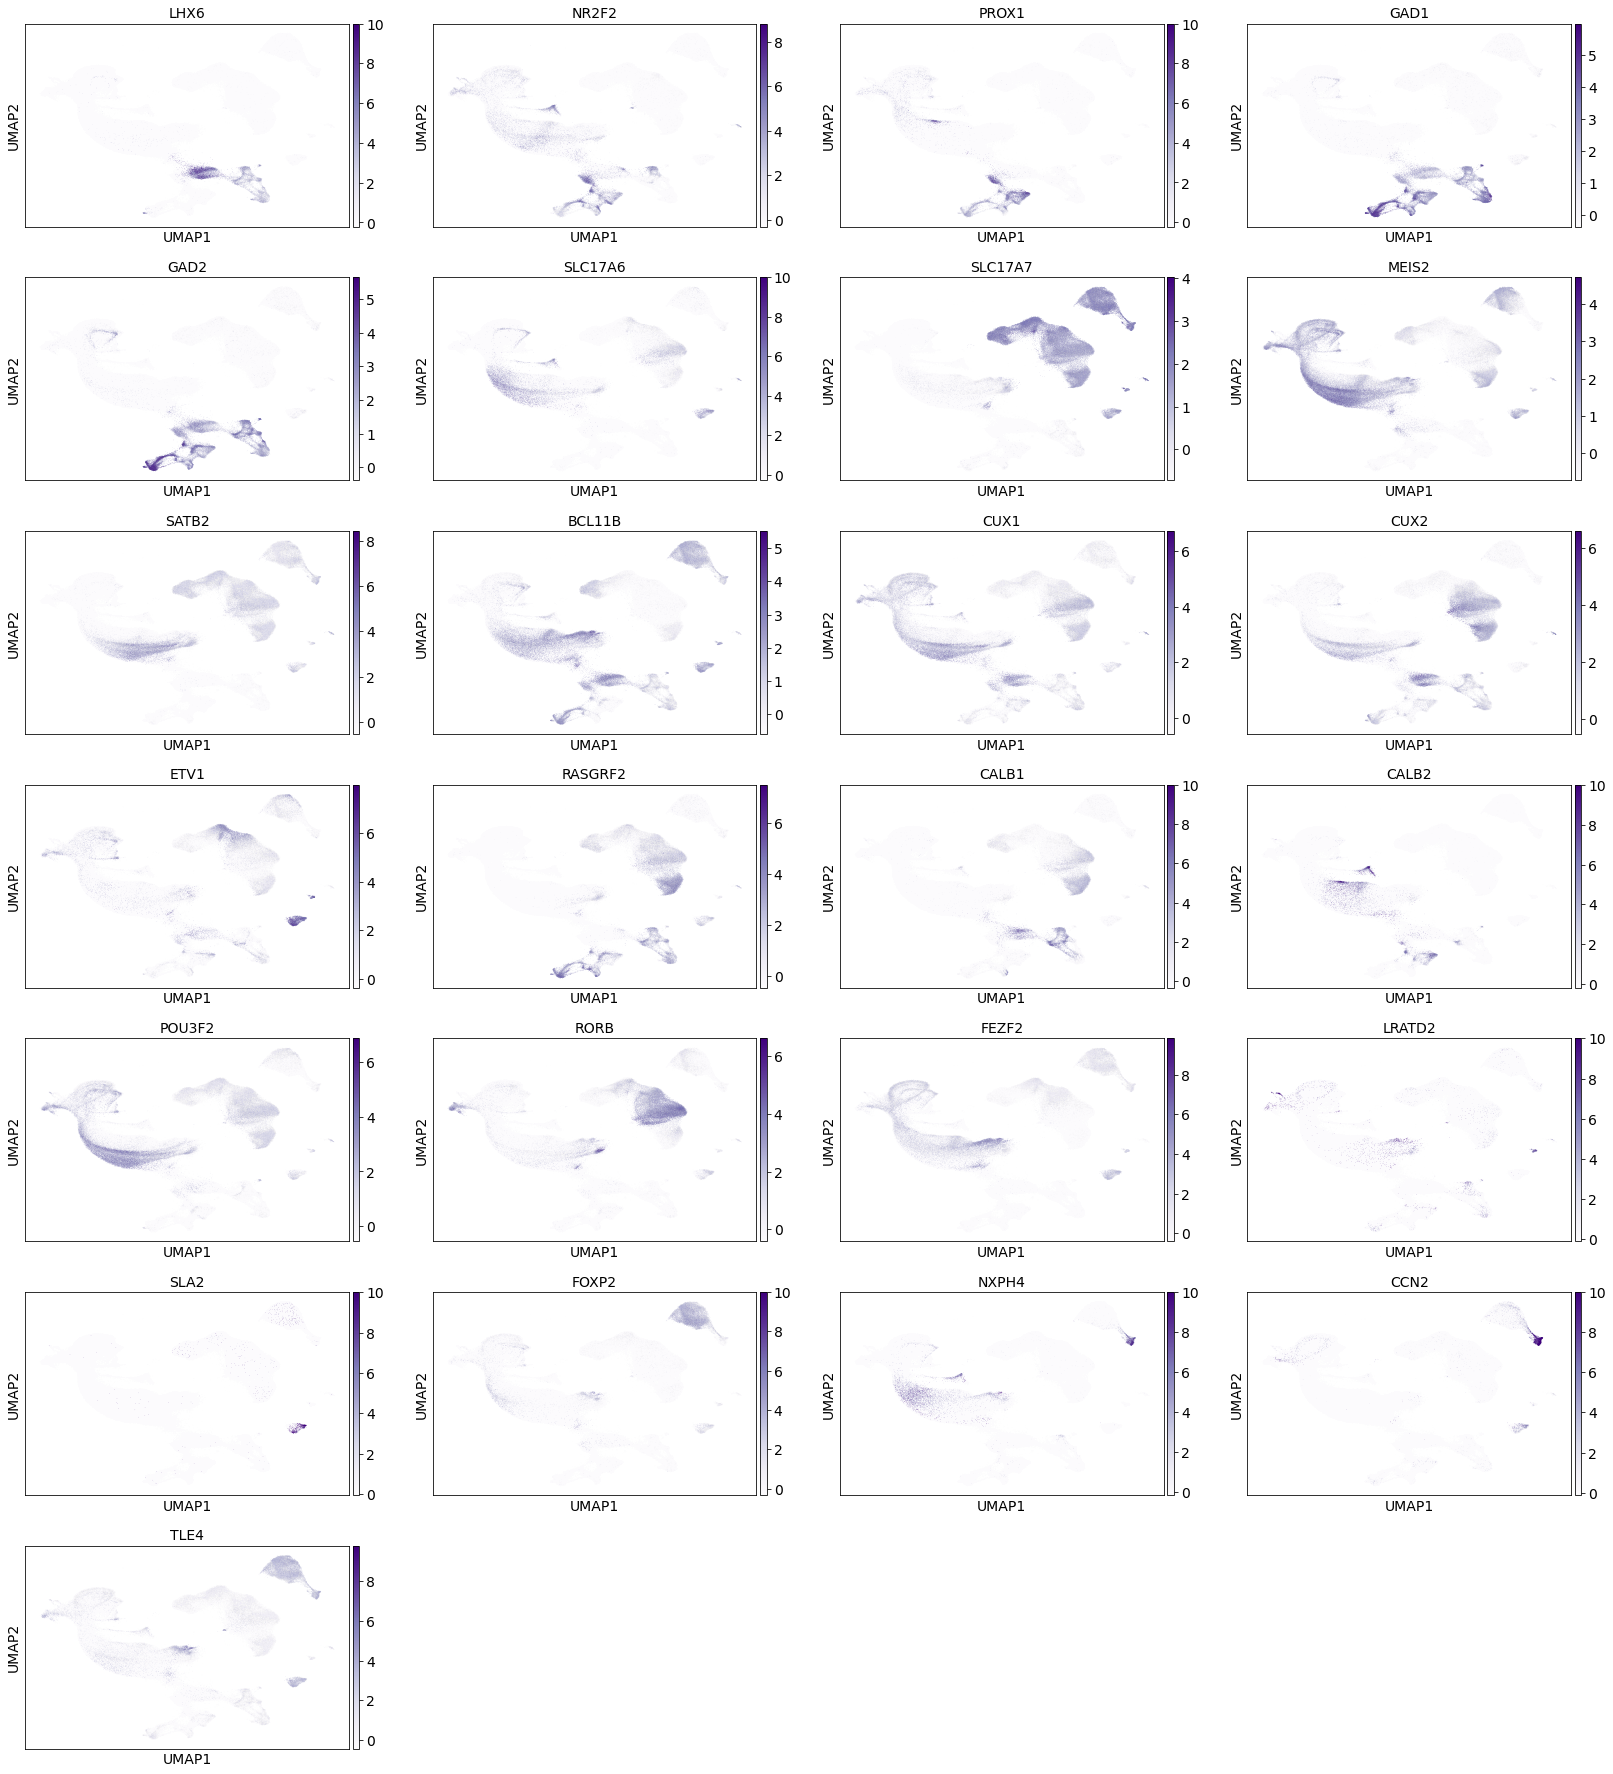

In [14]:
sc.pl.umap(adata,color=['LHX6','NR2F2','PROX1','GAD1','GAD2','SLC17A6','SLC17A7','MEIS2','SATB2','BCL11B','CUX1','CUX2','ETV1','RASGRF2','CALB1','CALB2','POU3F2','RORB','FEZF2','LRATD2','SLA2','FOXP2','NXPH4','CCN2','TLE4'],use_raw=False)

In [7]:
allencells=pd.read_csv('/wynton/group/ye/mtschmitz/mousefastqpool/BICCN_metadata.csv')
allennamedf=allencells['sample_name'].str.split('-|_',expand=True)
adatasplitnamedf=pd.DataFrame(adata.obs.index)[0].str.split('_',expand=True)
allenids=pd.DataFrame(allennamedf[0]+'_'+allennamedf[1]+'_'+allennamedf[2]+'_'+allennamedf[4])
allenids.index=allenids[0]
allenids['realind']=allencells.index
adataids=pd.DataFrame(adatasplitnamedf[0]+'_'+adatasplitnamedf[2]+'_'+adatasplitnamedf[3]+'_'+adatasplitnamedf[5])
adataids.index=adataids[0]
adataids['realind']=adata.obs.index
adata.obs['allen_cluster_label']='nan'
adata.obs['allen_class_label']='nan'
adata.obs.loc[adataids.loc[set(adataids[0])&set(allenids[0]),'realind'],'allen_cluster_label']=allencells.loc[allenids.loc[set(adataids[0])&set(allenids[0]),'realind'],:]['cluster_label'].tolist()
adata.obs.loc[adataids.loc[set(adataids[0])&set(allenids[0]),'realind'],'allen_class_label']=allencells.loc[allenids.loc[set(adataids[0])&set(allenids[0]),'realind'],:]['class_label'].tolist()
adata.obs['simplified_allen']=adata.obs['allen_cluster_label'].str.split('_',expand=True)[1]
adata.obs['simplified_allen']=[re.sub('\sCTX','',str(x)) for x in adata.obs['simplified_allen']]

In [10]:
adata.obs['simplified_allen'].value_counts()

None             175122
L4/5 IT           27822
L6 CT             18733
L2/3 IT            9535
L5 IT              7761
L6 IT              6745
Vip                5761
Sst                5442
Lamp5              4306
Pvalb              3683
L5 NP              3198
L6b                2298
Sncg               1472
L5/6 IT             665
L6 Car3             577
L5 PT               554
L2 IT RSP-ACA       403
Sst Chodl           297
Astro               257
Pax6                243
Oligo               235
Lamp5 Lhx6          226
L6 NP CT            202
Pvalb Vipr2         186
nan                 129
OPC                  60
Micro                48
Endo                 43
L5 PT RSP-ACA        10
Peri                  9
SMC                   7
VLMC                  5
PVM                   3
L5 IT TPE-ENT         3
CR                    2
L2/3 IT PPP           1
L3 RSP-ACA            1
L2 IT HATA            1
Name: simplified_allen, dtype: int64

Trying to set attribute `.obs` of view, copying.
... storing 'allen_cluster_label' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'allen_class_label' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'simplified_allen' as categorical


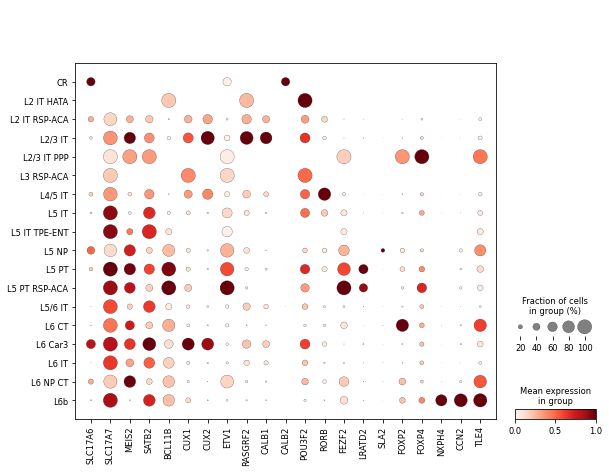

In [16]:
sc.pl.dotplot(adata[adata.obs.simplified_allen.str.contains('L[0-9]|CR'),:],groupby='simplified_allen',standard_scale='var',var_names=['SLC17A6','SLC17A7','MEIS2','SATB2','BCL11B','CUX1','CUX2','ETV1','RASGRF2','CALB1','CALB2','POU3F2','RORB','FEZF2','LRATD2','SLA2','FOXP2','FOXP4','NXPH4','CCN2','TLE4'])

... storing 'allen_cluster_label' as categorical
... storing 'allen_class_label' as categorical
... storing 'simplified_allen' as categorical


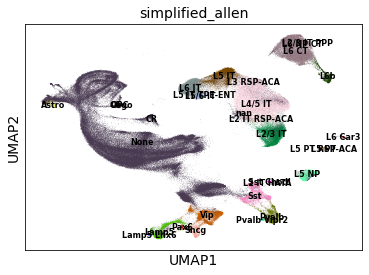

In [17]:
sc.pl.umap(adata,color=['simplified_allen'],legend_loc='on data',legend_fontsize=8)

In [25]:
adata.obs['dev_excit']=False
adata.obs['dev_excit']=adata.obs.leiden.isin(['2','5','4','18','14','17','16','38','16','12','25'])

... storing 'dev_excit' as categorical


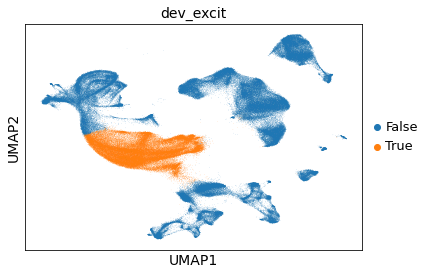

In [20]:
sc.pl.umap(adata,color='dev_excit')

In [26]:
adata.obs['condit']='Garbage'
adata.obs.loc[adata.obs['dev_excit'],'condit']='DevExcitatory'
adata.obs.loc[adata.obs.simplified_allen.str.contains('L[0-9]|CR'),'condit']='AdultExcitatory'

... storing 'condit' as categorical


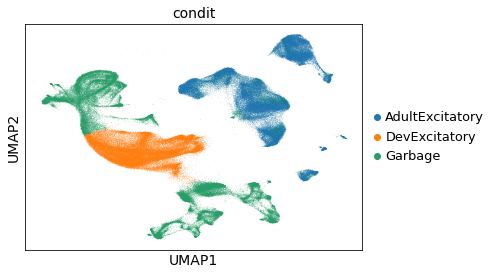

In [27]:
sc.pl.umap(adata,color='condit')

In [29]:
import diffxpy
import diffxpy.api as de


In [73]:
adata.X=adata.raw.X[:,adata.raw.var.index.isin(adata.var.index)].todense()

In [ ]:
sf=adata.X.mean(1) 
sf = sf/sf.mean()
adata.obs['size_factors']=sf

test = de.test.wald(
    data=adata[adata.obs['condit']!='Garbage',:],
    formula_loc="~ 1 + condit + size_factors",
    factor_loc_totest="condit",#as_numeric=['latent_time'],
    size_factors='size_factors',
    as_numeric=["size_factors"]
)
resultsdiffx=test.summary()
resultsdiffx['neg_log_q']=-test.log10_qval_clean()
resultsdiffx['signif']=(resultsdiffx['neg_log_q']>2) & (np.absolute(resultsdiffx['log2fc'])>1.2)
resultsdiffx=resultsdiffx.loc[resultsdiffx['log2fc'].argsort(),:]


training location model: True
training scale model: True
iter   0: ll=659721705.555739
iter   1: ll=599064869.515999, converged: 0.00% (loc: 0.78%, scale update: False), in 226.41sec
iter   2: ll=578297349.372605, converged: 0.00% (loc: 0.79%, scale update: False), in 223.37sec
iter   3: ll=573033203.346529, converged: 0.00% (loc: 0.80%, scale update: False), in 223.90sec
iter   4: ll=571916131.327515, converged: 0.00% (loc: 0.83%, scale update: False), in 226.60sec


In [42]:
resultsdiffx['mean']

3104     0.000007
2157     0.000033
6279     0.000020
4192     0.001990
1531     0.000387
           ...   
13824    0.000120
8617     0.001316
4558     0.000027
3697     0.000007
4816     0.000027
Name: mean, Length: 15000, dtype: float64

In [57]:
with pd.option_context('display.max_rows', 30, 'display.max_columns', 10):
    print(resultsdiffx.loc[resultsdiffx['mean']>.3,:])
    
list(resultsdiffx.loc[resultsdiffx['mean']>.3,'gene'])

          gene  pval  qval     log2fc      mean  ...   coef_mle   coef_sd  \
8899      IGHM   0.0   0.0  -8.014363  0.430748  ...  -8.014363  0.277707   
8894    IGFBP6   0.0   0.0  -7.689298  0.860742  ...  -7.689298  0.176874   
1341       ARC   0.0   0.0  -5.727171  0.672928  ...  -5.727171  0.076685   
2231      CD34   0.0   0.0  -5.705963  0.335880  ...  -5.705963  0.105692   
1268      ANO3   0.0   0.0  -5.431047  0.967645  ...  -5.431047  0.053572   
...        ...   ...   ...        ...       ...  ...        ...       ...   
2831     CSRP2   0.0   0.0   6.761689  0.520548  ...   6.761689  0.051861   
8896   IGFBPL1   0.0   0.0  10.108125  3.648660  ...  10.108125  0.149434   
14131   TUBB2B   0.0   0.0  10.496082  8.807545  ...  10.496082  0.066314   
8618    HBB-BS   0.0   0.0  12.664766  1.126008  ...  12.664766  0.587416   
8613    HBA-A1   0.0   0.0  13.981807  0.563562  ...  13.981807  1.087307   

                  ll  neg_log_q  signif  
8899   -85423.822490       30.0  

['IGHM',
 'IGFBP6',
 'ARC',
 'CD34',
 'ANO3',
 'SLC24A2',
 'PRUNE2',
 'GM11549',
 'SCN2B',
 'INKA2',
 'GM43670',
 'HIPK4',
 'RASGRP1',
 'ZMAT4',
 'CNTNAP1',
 'MYL4',
 'ETL4',
 'LYNX1',
 'EFHD2',
 'CAR10',
 'ZDHHC22',
 'NPTX1',
 'PTER',
 'PER3',
 'JCAD',
 'CIT',
 'EGR3',
 'HLF',
 'NPTX2',
 'LAMP5',
 'GPR158',
 'SYNE1',
 'SYT13',
 'ZFP365',
 'CX3CL1',
 'GABRA1',
 'THRB',
 'HTR2A',
 'KCNC4',
 'CAMK2A',
 'IPCEF1',
 'NR3C1',
 'RGS4',
 'HPCAL4',
 'SV2B',
 'UNC80',
 'DUSP3',
 'NRSN1',
 'DGKB',
 'GRIN2A',
 'SLC1A2',
 'KCNA2',
 'EGR1',
 'SLC2A13',
 'SLC4A10',
 'MRTFB',
 'SCN1B',
 'SNHG11',
 'SLC30A3',
 'DIRAS2',
 'BRINP3',
 'C030017B01RIK',
 'A830036E02RIK',
 'SLC12A5',
 'BAALC',
 'TRBC2',
 'RPH3A',
 'NRXN3',
 'HRH3',
 'AI593442',
 'CAMK2N1',
 'KLF9',
 'FAIM2',
 'ADGRA1',
 'PTPRN',
 'IGIP',
 'RORA',
 'KCNB1',
 'GM42772',
 'PLEC',
 'DEPTOR',
 'MT3',
 'SLC17A7',
 'NGEF',
 'DZANK1',
 'FSTL4',
 'SORCS3',
 'GFRA2',
 'PCSK2',
 'DKK3',
 'BHLHE40',
 'CACNG3',
 'VXN',
 'TRHDE',
 'PRKCB',
 'ETV5',
 'KCNA

In [ ]:
sc.pp.normalize_total(adata,exclude_highly_expressed=True)
sc.pp.log1p(adata)
#sc.pp.scale(adata,max_value=10)

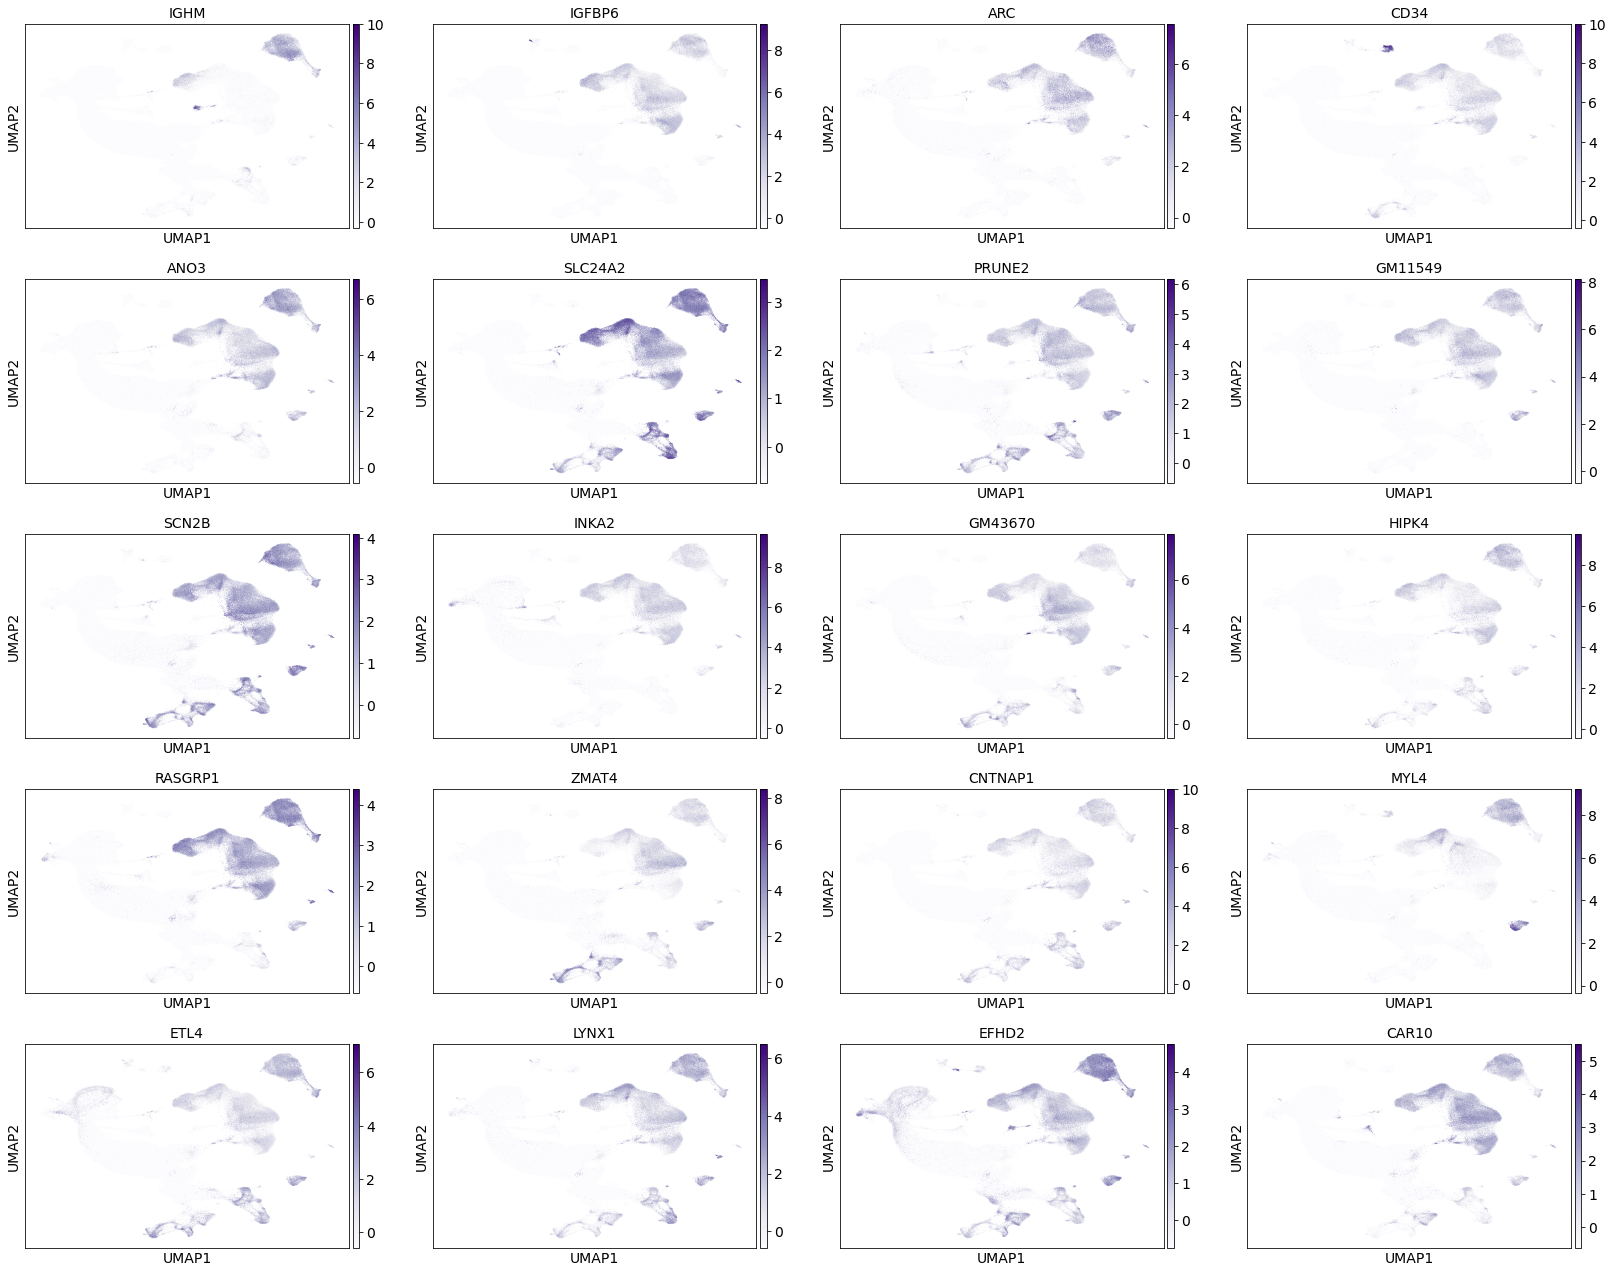

In [67]:
sc.pl.umap(adata,color=list(resultsdiffx.loc[resultsdiffx['mean']>.3,'gene'])[:20],use_raw=False)

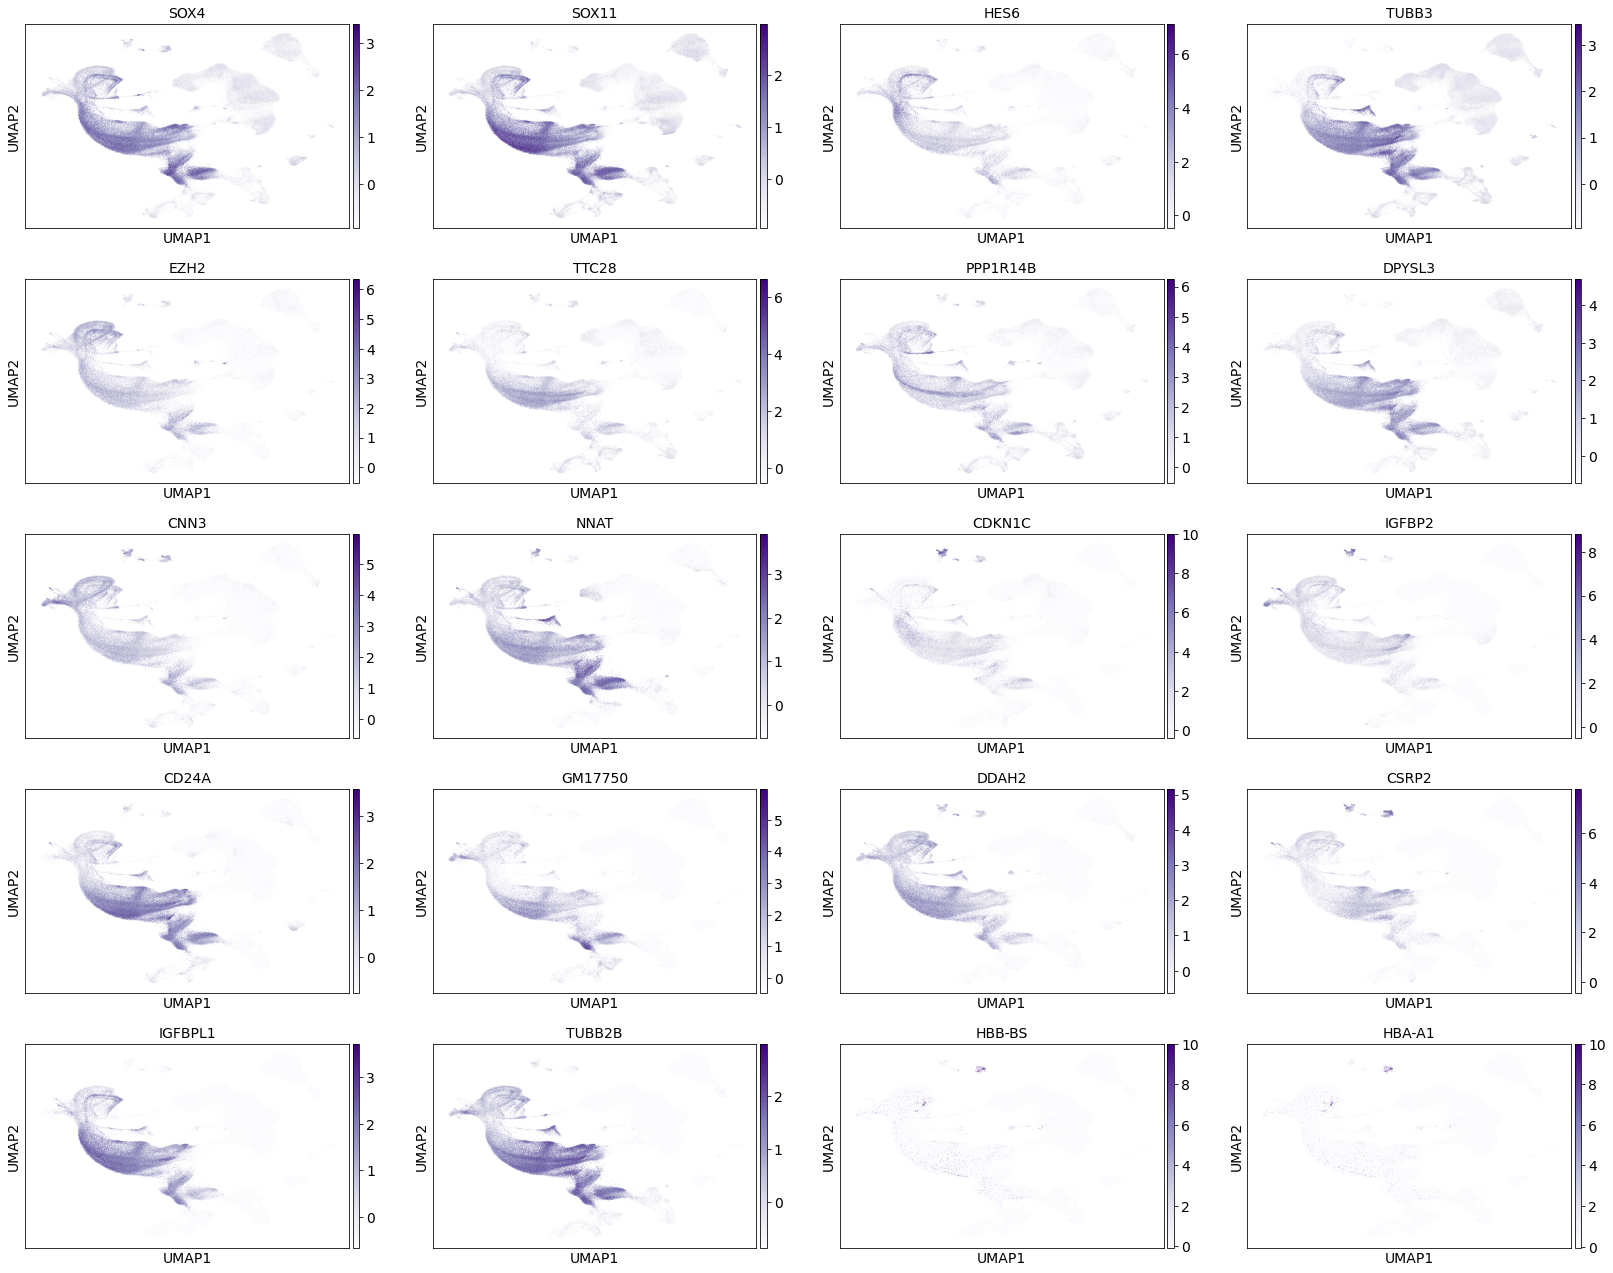

In [68]:
sc.pl.umap(adata,color=list(resultsdiffx.loc[resultsdiffx['mean']>.3,'gene'])[-20:],use_raw=False)

In [65]:
resultsdiffx.to_csv('/wynton/home/ye/mschmitz1/MatureVsDev.csv')

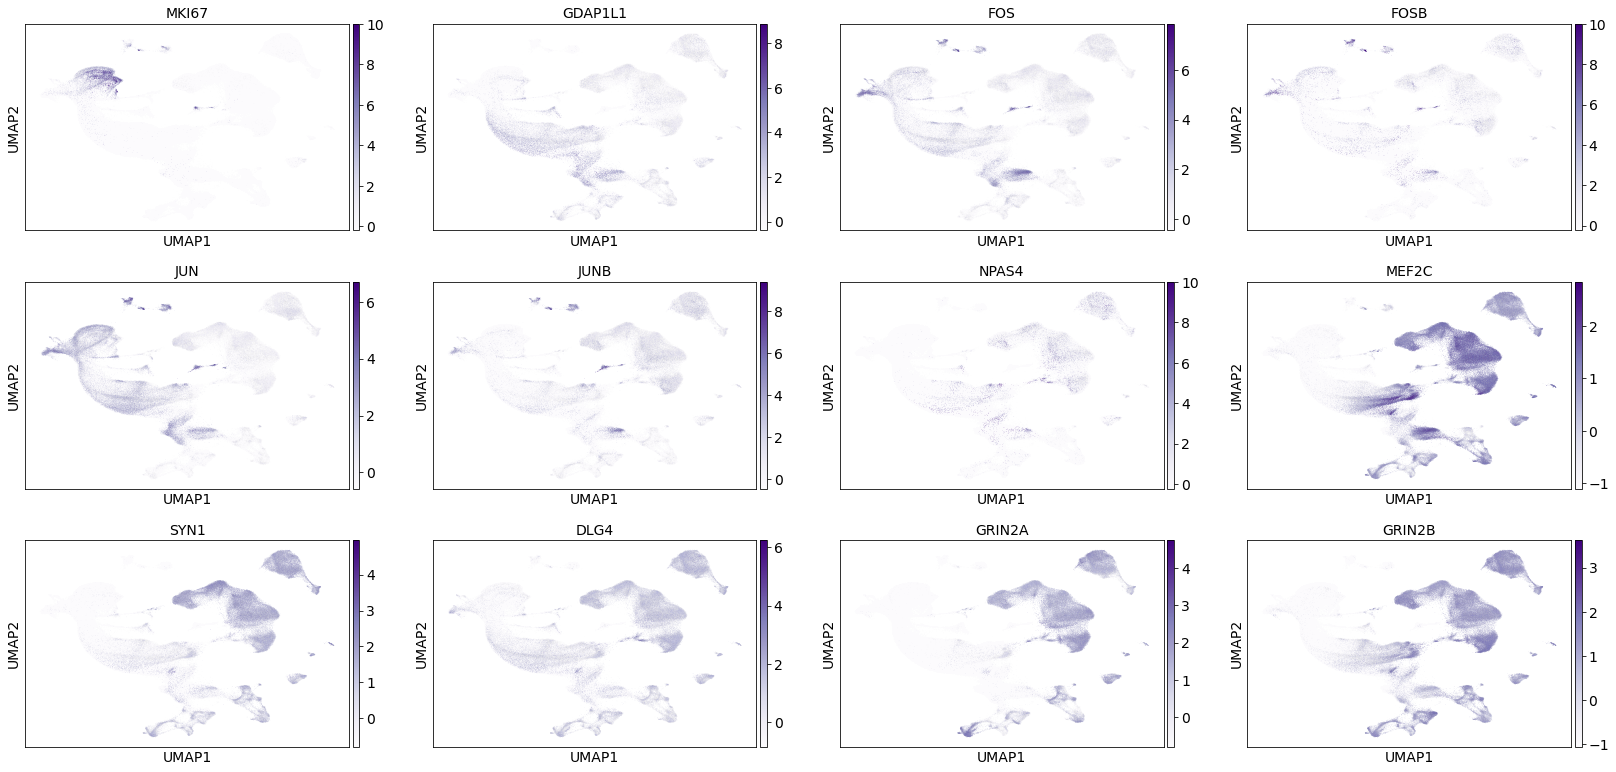

In [6]:
sc.pl.umap(adata,color=['MKI67','GDAP1L1','FOS','FOSB','JUN','JUNB','NPAS4','MEF2C','SYN1','DLG4','GRIN2A','GRIN2B'],use_raw=False)

In [4]:
adata

AnnData object with n_obs × n_vars = 276045 × 34894
    obs: 'latent_cell_probability', 'latent_RT_efficiency', 'n_genes', 'batch_name', 'dataset_name', 'timepoint', 'region', 'batch', 'clean_cellname', 'full_cellname', 'leiden', 'supervised_name', 'percent_ribo', 'percent_mito'
    var: 'feature_type-0-0', 'id-0-0', 'name-0-0', 'feature_type-1-0', 'id-1-0', 'name-1-0', 'feature_type-0-1', 'id-0-1', 'name-0-1', 'feature_type-1-1', 'id-1-1', 'name-1-1', 'feature_type-0-10', 'id-0-10', 'name-0-10', 'feature_type-1-10', 'id-1-10', 'name-1-10', 'feature_type-0-11', 'id-0-11', 'name-0-11', 'feature_type-1-11', 'id-1-11', 'name-1-11', 'feature_type-0-12', 'id-0-12', 'name-0-12', 'feature_type-1-12', 'id-1-12', 'name-1-12', 'feature_type-0-13', 'id-0-13', 'name-0-13', 'feature_type-1-13', 'id-1-13', 'name-1-13', 'feature_type-0-14', 'id-0-14', 'name-0-14', 'feature_type-1-14', 'id-1-14', 'name-1-14', 'feature_type-0-15', 'id-0-15', 'name-0-15', 'feature_type-1-15', 'id-1-15', 'name-1-15', 'fe